In [187]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [329]:
# define constants
RHO_ICE = 917 # kg/m^3
RHO_WATER = 1000 # kg/m^3
GRAVITY = 9.8 # m/s^2
SEC_PER_YEAR = 365*24*3600

# tuning params
uplift = 1e-3 # m/yr
slide_const = 1e-6
precip_rate = 0.1 # m/yr SWE
lapse_rate = 6.5 / 1000 # K/m
erosion_constant = 1e-3
melt_rate = 2 # m/(yr K) SWE

# simulation params
ela = 2500 # m
init_angle = 40 # degrees
init_height = ela
n_points = 1000
dt = 1 # years
n_years = 500000

def mountain(angle, h0, n_points):
    angle_rad = np.radians(angle)
    x0 = h0 / np.tan(angle_rad)
    x_vals = np.linspace(0, 2*x0, 2*n_points)
    z_vals = x_vals[:n_points] * np.tan(angle_rad)
    return x_vals, np.r_[z_vals,z_vals[::-1]]

def mountain(angle, h0, n_points):
    angle_rad = np.radians(angle)
    x0 = h0 / np.tan(angle_rad)
    x_vals = np.linspace(0, x0, n_points)
    z_vals = x_vals * np.tan(angle_rad)
    return x_vals, z_vals

# def mountain(angle, h0, n_points):
#     angle_rad = np.radians(angle)
#     x0 = h0 / np.tan(angle_rad)
#     x_vals = np.linspace(0, 2*x0, 2*n_points)
#     z_vals = np.zeros_like(x_vals)
#     z_vals[n_points:] = 0.5*(np.sin(x_vals[:n_points] * np.pi / (x0) - np.pi/2) + 1) * h0
#     return x_vals, z_vals

In [328]:
# approximate basal sliding speed based on the slope and ice thickness (m/yr)
def slide_speed(slide_const, ice_thickness, slope):
    safe_slope = np.clip(slope, -1e6, 1e6)
    sin_angle = safe_slope / np.sqrt(1+safe_slope**2)
    # n=3
    # A = 2e-25 * SEC_PER_YEAR
    # deform_speed = 2 * A / (n+1) * (RHO_ICE * GRAVITY * sin_angle)**n * ice_thickness ** (n+1)
    # print(np.max(deform_speed))
    return - slide_const * RHO_ICE * GRAVITY * ice_thickness * sin_angle

# erosion rate (m/yr)
def erosion(velocity, kg, l = 1):
    return kg * np.absolute(velocity) ** l

# temperature as a function of elevation
def temperature(z, ela, lapse_rate):
    return lapse_rate * (ela - z)

# melt rate (m/yr)
def melt(temp, melt_rate, precip_rate):
    return np.maximum(0, melt_rate * temp + precip_rate) * RHO_WATER / RHO_ICE

# precipitation rate (m/yr)
def precip(temp, precip_rate):
    return np.where(temp < 0, precip_rate * RHO_WATER / RHO_ICE, 0)

0.0006299318574928166 0.0 0.839099631177362


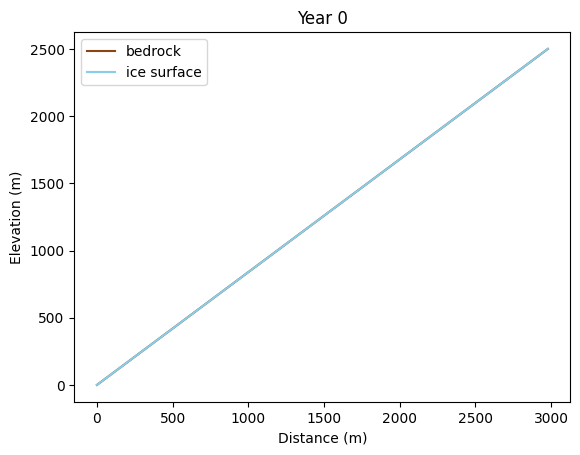

-0.16179954781773526 29.476044803565696 0.8397872279631429


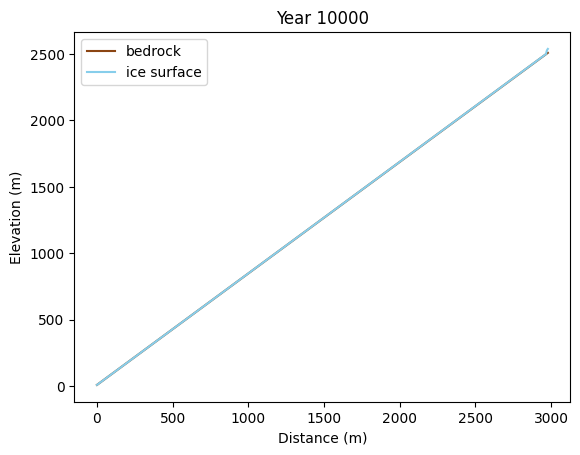

-0.3247893083059163 61.28926071872783 0.8404757178951172


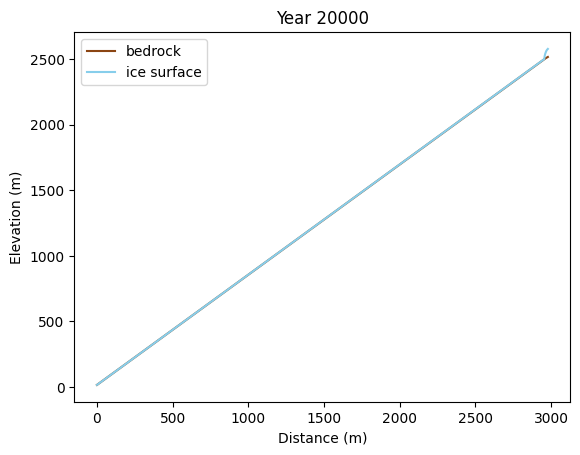

-0.47908880316141284 95.7452218753377 0.8411651032682812


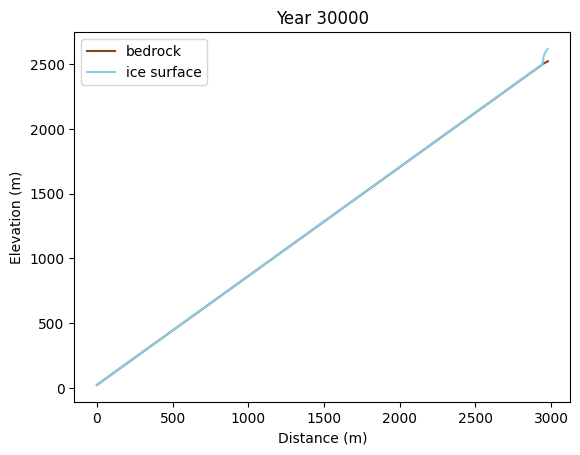

-0.6093890417792569 132.94786157162002 0.8418553855543678


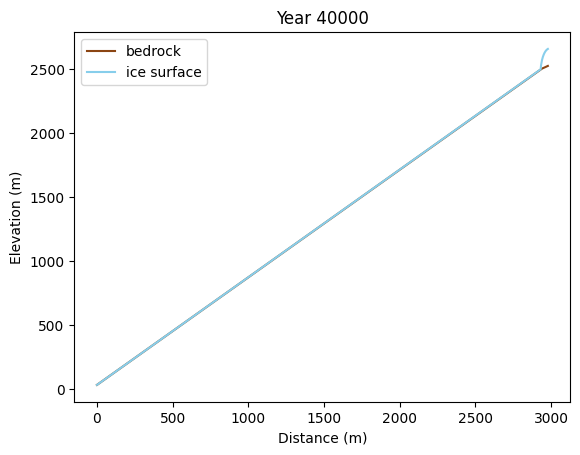

-0.7178912938870462 173.09590574340112 0.8425465661366616


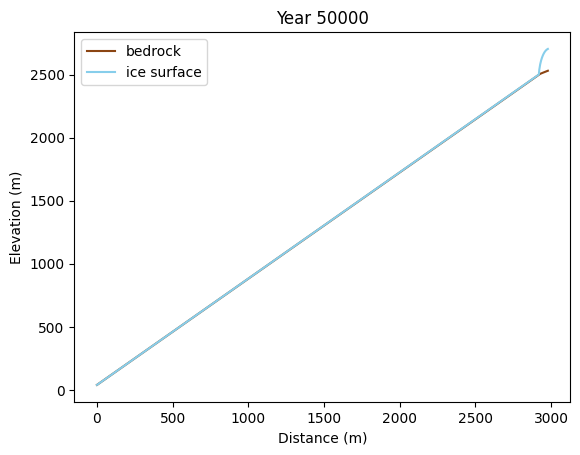

-0.8006216608100513 216.39068838810235 0.843238646397424


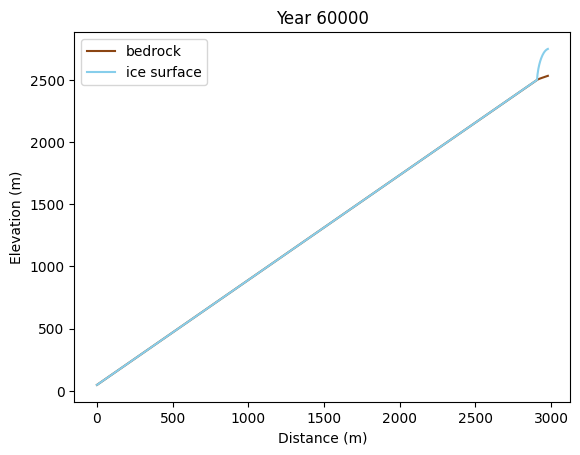

-0.8634098433194716 263.00324091359596 0.8439316277745093


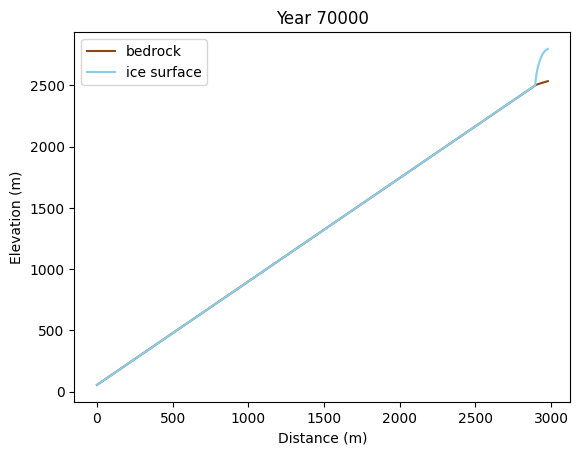

-0.908706713079319 313.0619241996444 0.844625511594927


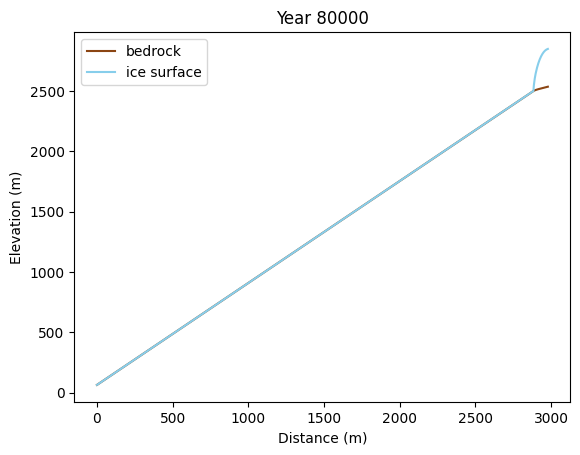

-0.9452328082923677 366.65772235329007 0.8453202992756701


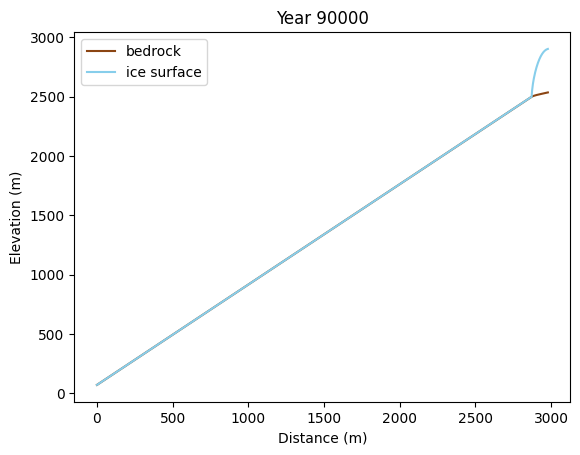

-0.9584600219391509 423.85416736201506 0.8460159921716013


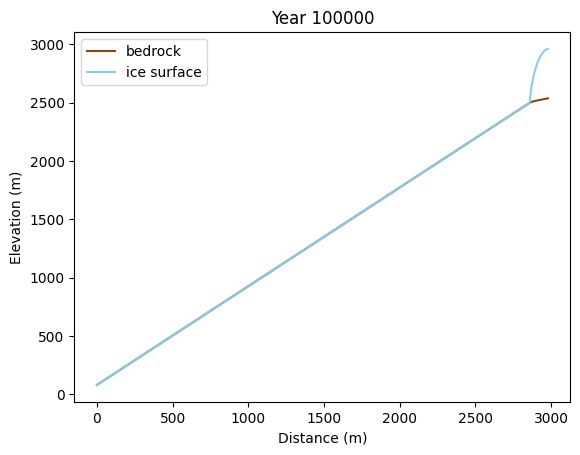

-0.9868026391702119 484.69139234148963 0.8467125917292151


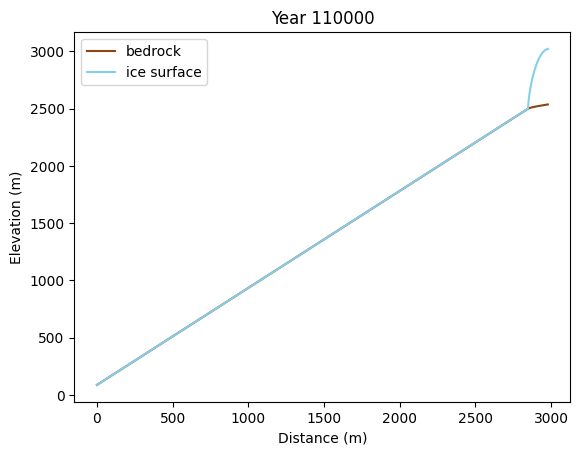

-1.0054186594665757 549.2117784234101 0.8474100992902436


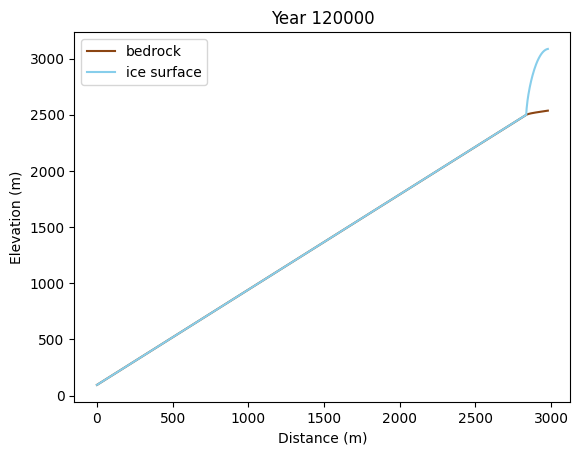

-1.010395718992737 617.4247354288559 0.8481085162538875


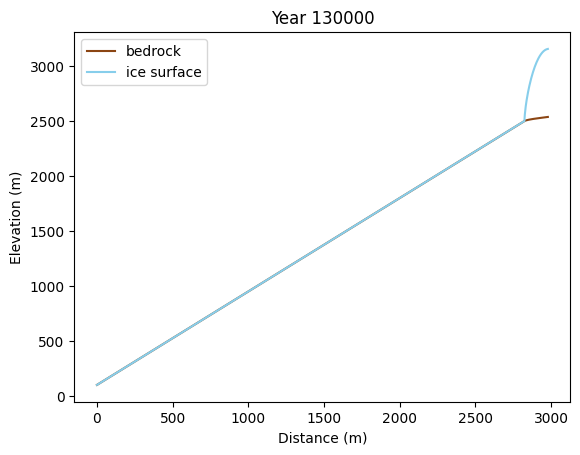

-1.0176830142969375 689.3411386764194 0.8488078440277604


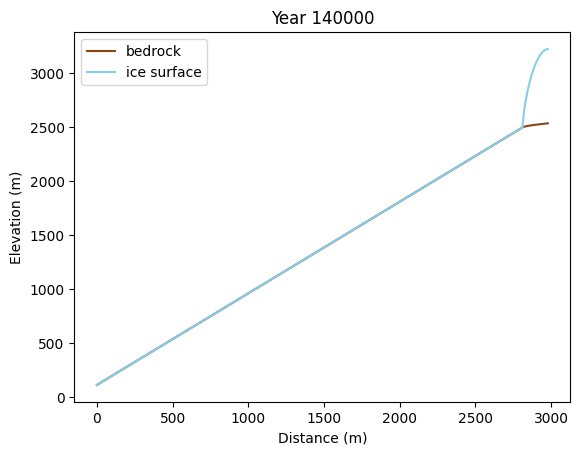

-1.0203298116616282 764.9829359950081 0.8495080840461924


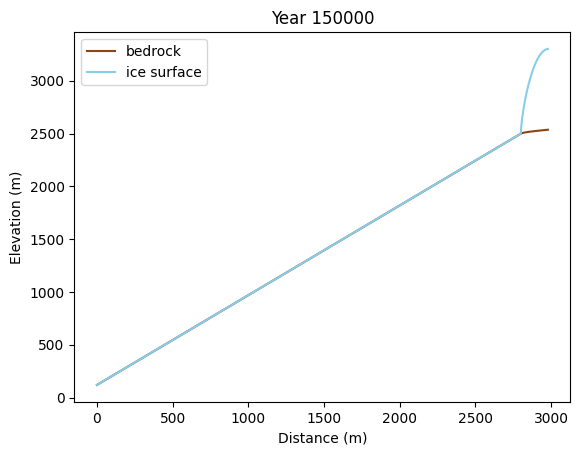

-1.0230959992814332 844.3239666793326 0.8502092376537576


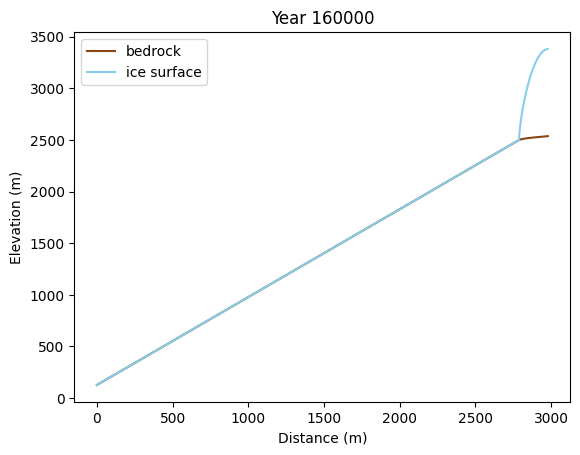

-1.029937838381593 927.371796613107 0.8509113063223595


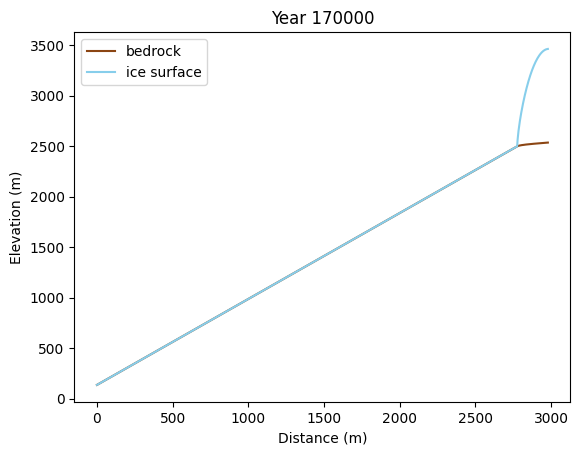

-1.0306010915236115 1014.0974512686886 0.8516142914270404


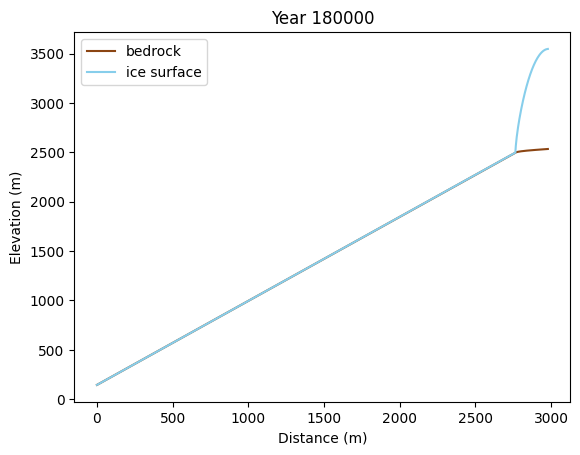

KeyboardInterrupt: 

In [330]:
# initialize domain
x, bed = mountain(init_angle, init_height, n_points)
ice = np.zeros_like(bed)
sediment = np.zeros_like(bed)
dx = x[1] - x[0]

# time evolution
for t in range(int(n_years/dt)):
    slope = np.gradient(bed, x)

    # temperature, accumulation, melt
    temp = temperature(bed + ice, ela, lapse_rate)
    snow = precip(temp, precip_rate)
    melt_amt = melt(temp, melt_rate, precip_rate)
    
    # update ice (mass balance)
    ice += (snow - melt_amt) * dt

    # compute sliding speed and erosion
    u = slide_speed(slide_const, ice, slope)
    E = erosion(u, erosion_constant)

    d_ice = np.diff(ice) / dx * dt
    ice += np.where(u<0, -np.r_[d_ice * u[1:],[0]] + np.r_[[0],d_ice * u[1:]], np.r_[[0], d_ice*u[:-1]] - np.r_[d_ice*u[:-1],[0]])
    
    d_sed = np.diff(E) / dx * dt
    deposit = np.where(u<0, -np.r_[d_sed * u[1:],[0]] + np.r_[[0],d_sed * u[1:]], np.r_[[0], d_sed*u[:-1]] - np.r_[d_sed*u[:-1],[0]])

    # sediment += (E - deposit) * dt
    # D =np.where(ice-melt_amt>=0, melt_amt * np.sum(sediment) / np.sum(np.clip(ice,0.01,1)),0)
    # sediment -= D

    
    # update bed with uplift and erosion
    bed += (uplift - E + deposit) * dt
    # bed += uplift * dt

    # prevent negative ice
    ice = np.maximum(ice, 0)

    # optional: visualize every few hundred years
    if t % 10000 == 0:
        print(np.min(u), np.max(ice), np.max(slope))
        plt.clf()
        plt.plot(x, bed, 'saddlebrown', label='bedrock')
        plt.plot(x, bed + ice, 'skyblue', label='ice surface')
        plt.title(f"Year {int(t*dt)}")
        plt.xlabel("Distance (m)")
        plt.ylabel("Elevation (m)")
        plt.legend()
        plt.pause(0.1)

plt.show()

In [333]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Physical constants
RHO_ICE = 917  # kg/m^3
RHO_WATER = 1000  # kg/m^3
GRAVITY = 9.8  # m/s^2
SEC_PER_YEAR = 365 * 24 * 3600

# Simulation parameters - BALANCED FOR STABILITY
UPLIFT = 1e-3  # m/yr - now visible
PRECIP_RATE = 0.5  # m/yr SWE - reduced
LAPSE_RATE = 6.5 / 1000  # K/m
EROSION_CONSTANT = 5e-4  # Much smaller - only erodes under thick flowing ice
MELT_RATE = 3.0  # m/(yr K) SWE - increased to balance accumulation better
ELA = 2500  # m
DT = 5  # years - larger base timestep (adaptive will reduce if needed)
N_YEARS = 200000  # 2 million years to see full equilibrium
N_POINTS = 150  # Reduced for speed (was 200)
INIT_ANGLE = 30  # degrees
INIT_HEIGHT = 2500  # m - start at ELA

# Ice flow parameters - MUCH LARGER for proper flow
A_FLOW = 2.4e-24  # Pa^-n s^-1 (standard Glen's law)
N_GLEN = 3  # Glen's exponent
SLIDE_FACTOR = 5e-12  # m Pa^-1 s^-1 - sliding coefficient

# Temperature-dependent flow enhancement
TEMP_FLOW_FACTOR = 3.0  # Warmer ice flows 3x faster

# Slope-dependent accumulation
MAX_ACCUM_SLOPE = 0.4  # ~22 degrees - steeper slopes shed snow

# Performance optimizations
MIN_DT = 0.5  # Minimum timestep (years) - prevent it from getting too small
MAX_DT = 10  # Maximum timestep (years)
SAVE_INTERVAL = 2000  # Save every 2000 years instead of 1000


def create_mountain(angle, h0, n_points):
    """Create symmetric triangular mountain"""
    angle_rad = np.radians(angle)
    half_base = h0 / np.tan(angle_rad)
    
    x_vals = np.linspace(0, 2 * half_base, n_points)
    bed = np.zeros(n_points)
    
    mid_point = n_points // 2
    
    # Left side (ascending)
    for i in range(mid_point):
        bed[i] = (i / mid_point) * h0
    
    # Right side (descending)
    for i in range(mid_point, n_points):
        bed[i] = ((n_points - 1 - i) / mid_point) * h0
    
    return x_vals, bed


def calculate_surface_slope(surface, dx):
    """Calculate surface slope (not bed slope!)"""
    slope = np.zeros_like(surface)
    slope[1:-1] = (surface[2:] - surface[:-2]) / (2 * dx)
    slope[0] = (surface[1] - surface[0]) / dx
    slope[-1] = (surface[-1] - surface[-2]) / dx
    return slope


def calculate_mass_balance(elevation, ela, precip_rate, melt_rate, lapse_rate, bed_slope):
    """Calculate net mass balance with slope-dependent accumulation"""
    temp = lapse_rate * (ela - elevation)
    
    # Slope factor - steep slopes can't hold as much snow
    slope_factor = np.ones_like(bed_slope)
    abs_slope = np.abs(bed_slope)
    # Linear reduction above threshold slope
    slope_factor = np.where(abs_slope > MAX_ACCUM_SLOPE, 
                           1.0 - (abs_slope - MAX_ACCUM_SLOPE) / (0.6 - MAX_ACCUM_SLOPE),
                           1.0)
    slope_factor = np.maximum(slope_factor, 0.1)  # At least 10% accumulation
    
    # Accumulation where T < 0, reduced on steep slopes
    accumulation = np.where(temp < 0, 
                           precip_rate * (RHO_WATER / RHO_ICE) * slope_factor, 
                           0.0)
    
    # Ablation where T > 0
    ablation = np.where(temp > 0, 
                       melt_rate * temp * (RHO_WATER / RHO_ICE),
                       0.0)
    
    return accumulation - ablation


def calculate_ice_flux_sia(ice, surface_slope, dx, dt, surface_elevation, ela, lapse_rate):
    """
    Shallow Ice Approximation (SIA) with temperature-dependent flow
    Warmer ice (closer to melting) flows faster
    """
    n = N_GLEN
    
    # Ice thickness at cell edges (staggered grid)
    H_edges = 0.5 * (ice[:-1] + ice[1:])
    
    # Surface slope at edges
    slope_edges = (surface_slope[:-1] + surface_slope[1:]) / 2
    
    # Surface elevation at edges for temperature calculation
    elev_edges = 0.5 * (surface_elevation[:-1] + surface_elevation[1:])
    
    # Temperature at edges (relative to pressure melting point)
    temp_edges = lapse_rate * (ela - elev_edges)
    
    # Diffusivity at edges
    D = np.zeros_like(H_edges)
    for i in range(len(H_edges)):
        if H_edges[i] > 0.1:  # Only where ice exists
            # Driving stress
            abs_slope = abs(slope_edges[i])
            if abs_slope < 1e-10:
                continue
            
            # Cap slope to prevent instabilities
            abs_slope = min(abs_slope, 0.3)
            
            # Temperature enhancement factor (warmer ice flows faster)
            # Ice at 0°C flows much faster than ice at -10°C
            if temp_edges[i] > -1:  # Within 1°C of melting
                temp_factor = TEMP_FLOW_FACTOR
            elif temp_edges[i] > -5:  # Moderately cold
                temp_factor = 1.0 + (TEMP_FLOW_FACTOR - 1.0) * (temp_edges[i] + 5) / 4
            else:  # Cold ice
                temp_factor = 1.0
                
            # Glen's law diffusivity (m^2/s) with temperature enhancement
            factor = 2 * A_FLOW / (n + 2) * temp_factor
            tau = (RHO_ICE * GRAVITY * abs_slope) ** n
            D[i] = factor * tau * H_edges[i] ** (n + 2)
            
            # Add sliding contribution (also enhanced by warmth)
            slide_diff = SLIDE_FACTOR * RHO_ICE * GRAVITY * H_edges[i]**2 * abs_slope * temp_factor
            D[i] += slide_diff
            
            # Additional pressure-driven flow for thick ice (hydrostatic pressure effect)
            # Very thick ice columns spread laterally due to their own weight
            if H_edges[i] > 500:  # Over 500m thick
                pressure_factor = 1.0 + (H_edges[i] - 500) / 500  # Linear increase
                D[i] *= pressure_factor
            
            # Convert to m^2/yr and cap maximum diffusivity
            D[i] *= SEC_PER_YEAR
            D[i] = min(D[i], 5e6)  # Increased cap for better drainage
    
    # Calculate flux at edges: Q = -D * dh/dx
    flux = -D * (ice[1:] - ice[:-1]) / dx
    
    # Calculate flux divergence: dh/dt = -dQ/dx
    dice_dt = np.zeros_like(ice)
    dice_dt[1:-1] = -(flux[1:] - flux[:-1]) / dx
    
    # Boundary conditions (no flux at boundaries)
    dice_dt[0] = 0
    dice_dt[-1] = 0
    
    # Adaptive timestepping for stability with limits
    if np.max(np.abs(dice_dt)) > 0:
        # CFL condition: dt < dx^2 / (2*D_max)
        D_max = np.max(D) if len(D) > 0 else 0
        if D_max > 0:
            dt_max = 0.25 * dx**2 / D_max
            # Clamp between MIN_DT and MAX_DT
            dt_effective = np.clip(min(dt, dt_max), MIN_DT, MAX_DT)
        else:
            dt_effective = dt
    else:
        dt_effective = dt
    
    return dice_dt, dt_effective, flux


def calculate_erosion_rate(ice, flux, dx):
    """Calculate erosion rate - only under flowing ice"""
    erosion = np.zeros_like(ice)
    
    for i in range(1, len(ice)-1):
        if ice[i] > 10:  # Only erode under thick ice (>10m)
            # Estimate sliding velocity from flux
            velocity = abs(flux[i-1] / (ice[i] + 0.01))  # m/yr
            
            # Erosion scales with sliding velocity
            erosion[i] = EROSION_CONSTANT * velocity
            
            # Cap maximum erosion rate
            erosion[i] = min(erosion[i], 0.01)  # 10 mm/yr max
    
    return erosion


def run_simulation():
    """Main simulation loop"""
    print("=" * 70)
    print("GLACIAL EROSION SIMULATION - FIXED VERSION")
    print("=" * 70)
    print(f"Parameters:")
    print(f"  Uplift: {UPLIFT*1000:.2f} mm/yr")
    print(f"  Precipitation: {PRECIP_RATE} m/yr")
    print(f"  Melt rate: {MELT_RATE} m/(yr·K)")
    print(f"  ELA: {ELA} m")
    print(f"  Glen's A: {A_FLOW:.2e} Pa^-n s^-1")
    print("=" * 70)
    
    # Initialize
    x, bed = create_mountain(INIT_ANGLE, INIT_HEIGHT, N_POINTS)
    ice = np.zeros_like(bed)
    dx = x[1] - x[0]
    
    print(f"\nDomain: {len(x)} points, dx = {dx:.1f} m")
    print(f"Mountain: peak at {np.max(bed):.1f} m\n")
    
    # Storage for animation
    time_points = [0]
    bed_history = [bed.copy()]
    ice_history = [ice.copy()]
    
    year = 0
    step = 0
    last_print_time = 0
    print_interval = 5000  # Print every 5000 years
    
    # Pre-allocate arrays for speed
    surface = np.zeros_like(bed)
    mass_balance = np.zeros_like(bed)
    erosion = np.zeros_like(bed)
    
    while year < N_YEARS:
        # Check for errors
        if np.any(np.isnan(ice)) or np.any(np.isnan(bed)):
            print(f"ERROR: NaN at year {year}")
            break
            
        if np.max(ice) > 2000:
            print(f"WARNING: Ice too thick at year {year}: {np.max(ice):.1f} m - capping")
            ice = np.minimum(ice, 2000)  # Cap at 2km (realistic for glaciers)
        
        # Surface elevation and slope (reuse arrays)
        np.add(bed, ice, out=surface)
        surface_slope = calculate_surface_slope(surface, dx)
        bed_slope = calculate_surface_slope(bed, dx)
        
        # Mass balance (with slope-dependent accumulation)
        mass_balance = calculate_mass_balance(surface, ELA, PRECIP_RATE, 
                                             MELT_RATE, LAPSE_RATE, bed_slope)
        
        # Ice flow (SIA with temperature and pressure effects)
        dice_dt_flow, dt_effective, flux = calculate_ice_flux_sia(ice, surface_slope, dx, DT, 
                                                                   surface, ELA, LAPSE_RATE)
        
        # Update ice thickness (vectorized)
        ice += (mass_balance + dice_dt_flow) * dt_effective
        np.maximum(ice, 0, out=ice)  # No negative ice (in-place)
        
        # Erosion (only under thick flowing ice)
        erosion = calculate_erosion_rate(ice, flux, dx)
        
        # Update bedrock (vectorized)
        bed += (UPLIFT - erosion) * dt_effective
        
        year += dt_effective
        step += 1
        
        # Save for visualization (less frequently)
        if year >= time_points[-1] + SAVE_INTERVAL:
            time_points.append(year)
            bed_history.append(bed.copy())
            ice_history.append(ice.copy())
        
        # Print progress (less frequently)
        if year >= last_print_time + print_interval:
            last_print_time = year
            
            max_ice = np.max(ice)
            mean_ice = np.mean(ice[ice > 1]) if np.any(ice > 1) else 0
            total_ice = np.sum(ice) * dx / 1e6  # km^3
            max_ero = np.max(erosion) * 1000
            peak_height = np.max(bed)
            
            # Calculate mass balance stats
            accum_total = np.sum(np.maximum(mass_balance, 0)) * dx
            ablat_total = np.sum(np.maximum(-mass_balance, 0)) * dx
            
            # Calculate effective timestep
            print(f"Year {int(year):7d}: Ice max={max_ice:6.1f}m mean={mean_ice:5.1f}m "
                  f"vol={total_ice:6.2f}km³ | Peak={peak_height:.1f}m | "
                  f"Ero={max_ero:4.2f}mm/yr | dt={dt_effective:.2f}yr | Steps/kyr={1000/dt_effective:.0f}")
    
    # Add final point if not already saved
    if time_points[-1] < year:
        time_points.append(year)
        bed_history.append(bed.copy())
        ice_history.append(ice.copy())
    
    return x, time_points, bed_history, ice_history


def create_plotly_animation(x, time_points, bed_history, ice_history):
    """Create interactive Plotly visualization"""
    print("\nCreating visualization...")
    
    # Calculate statistics
    max_ice_list = [np.max(ice) for ice in ice_history]
    ice_volume_list = [np.sum(ice) * (x[1]-x[0]) / 1e9 for ice in ice_history]  # km^3
    peak_height_list = [np.max(bed) for bed in bed_history]
    
    # Convert time to millions of years
    time_myr = [t / 1e6 for t in time_points]
    
    # Find max surface elevation for plot limits
    max_surface = max([np.max(bed_history[i] + ice_history[i]) for i in range(len(time_points))])
    y_max = max_surface * 1.15  # Add 15% headroom
    
    # Create subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Mountain Profile', 'Maximum Ice Thickness', 
                       'Peak Height', 'Ice Volume'),
        specs=[[{"colspan": 2}, None],
               [{}, {}]],
        row_heights=[0.6, 0.4],
        vertical_spacing=0.15
    )
    
    # Create frames
    frames = []
    for i, year in enumerate(time_points):
        bed = bed_history[i]
        ice = ice_history[i]
        surface = bed + ice
        
        frame_data = [
            go.Scatter(x=x/1000, y=bed, mode='lines', 
                      fill='tozeroy', fillcolor='rgb(139,90,43)',
                      line=dict(color='rgb(101,67,33)', width=2),
                      name='Bedrock', showlegend=(i==0)),
            go.Scatter(x=x/1000, y=surface, mode='lines',
                      fill='tonexty', fillcolor='rgba(173,216,230,0.6)',
                      line=dict(color='royalblue', width=2),
                      name='Ice Surface', showlegend=(i==0)),
            go.Scatter(x=time_myr[:i+1], 
                      y=max_ice_list[:i+1],
                      mode='lines', line=dict(color='blue', width=2),
                      showlegend=False),
            go.Scatter(x=time_myr[:i+1], 
                      y=peak_height_list[:i+1],
                      mode='lines', line=dict(color='brown', width=2),
                      showlegend=False),
            go.Scatter(x=time_myr[:i+1], 
                      y=ice_volume_list[:i+1],
                      mode='lines', line=dict(color='cyan', width=2),
                      showlegend=False),
        ]
        
        frames.append(go.Frame(data=frame_data, name=str(year)))
    
    # Initial data
    fig.add_trace(frames[0].data[0], row=1, col=1)
    fig.add_trace(frames[0].data[1], row=1, col=1)
    fig.add_trace(frames[0].data[2], row=2, col=1)
    fig.add_trace(frames[0].data[3], row=2, col=2)
    
    # Update axes with proper labels
    fig.update_xaxes(title_text="Distance (km)", row=1, col=1)
    fig.update_yaxes(title_text="Elevation (m)", range=[0, y_max], row=1, col=1)
    
    fig.update_xaxes(title_text="Time (Myr)", row=2, col=1)
    fig.update_yaxes(title_text="Max Ice Thickness (m)", row=2, col=1)
    
    fig.update_xaxes(title_text="Time (Myr)", row=2, col=2)
    fig.update_yaxes(title_text="Peak Elevation (m)", row=2, col=2)
    
    fig.update_layout(
        height=800,
        title_text="Glacial Erosion Simulation - Shallow Ice Approximation",
        updatemenus=[{
            "type": "buttons",
            "showactive": False,
            "buttons": [
                {"label": "▶ Play", "method": "animate",
                 "args": [None, {"frame": {"duration": 50, "redraw": True},
                                "fromcurrent": True, "transition": {"duration": 0}}]},
                {"label": "⏸ Pause", "method": "animate",
                 "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                   "mode": "immediate"}]}
            ],
            "x": 0.12, "y": 1.12
        }],
        sliders=[{
            "active": 0,
            "yanchor": "top",
            "y": -0.05,
            "xanchor": "left",
            "currentvalue": {
                "prefix": "Time: ",
                "suffix": " Myr",
                "visible": True,
                "xanchor": "right"
            },
            "steps": [{"args": [[f.name], {"frame": {"duration": 0, "redraw": True},
                                           "mode": "immediate"}],
                      "label": f"{float(f.name)/1e6:.2f}",
                      "method": "animate"} for f in frames[::5]]  # Every 5th frame for speed
        }]
    )
    
    fig.frames = frames
    
    return fig


if __name__ == "__main__":
    # Run simulation
    x, time_points, bed_history, ice_history = run_simulation()
    
    # Create visualization
    fig = create_plotly_animation(x, time_points, bed_history, ice_history)
    
    print("\nOpening interactive plot...")
    fig.show()
    
    print("\nSimulation complete!")
    print("- Click Play to animate")
    print("- Use slider to jump to any time")
    print("- Zoom and pan the plots")

GLACIAL EROSION SIMULATION - FIXED VERSION
Parameters:
  Uplift: 1.00 mm/yr
  Precipitation: 0.5 m/yr
  Melt rate: 3.0 m/(yr·K)
  ELA: 2500 m
  Glen's A: 2.40e-24 Pa^-n s^-1

Domain: 150 points, dx = 58.1 m
Mountain: peak at 2466.7 m

Year    5000: Ice max=   0.0m mean=  0.0m vol=  0.00km³ | Peak=2471.7m | Ero=0.00mm/yr | dt=5.00yr | Steps/kyr=200
Year   10000: Ice max=   0.0m mean=  0.0m vol=  0.00km³ | Peak=2476.7m | Ero=0.00mm/yr | dt=5.00yr | Steps/kyr=200
Year   15000: Ice max=   0.0m mean=  0.0m vol=  0.00km³ | Peak=2481.7m | Ero=0.00mm/yr | dt=5.00yr | Steps/kyr=200
Year   20000: Ice max=   0.0m mean=  0.0m vol=  0.00km³ | Peak=2486.7m | Ero=0.00mm/yr | dt=5.00yr | Steps/kyr=200
Year   25000: Ice max=   0.0m mean=  0.0m vol=  0.00km³ | Peak=2491.7m | Ero=0.00mm/yr | dt=5.00yr | Steps/kyr=200
Year   30000: Ice max=   0.0m mean=  0.0m vol=  0.00km³ | Peak=2496.7m | Ero=0.00mm/yr | dt=5.00yr | Steps/kyr=200
Year   35000: Ice max=  17.9m mean= 17.9m vol=  0.00km³ | Peak=2501.7m | Er


Simulation complete!
- Click Play to animate
- Use slider to jump to any time
- Zoom and pan the plots
